In [9]:
# Trun off annoying ipykernel warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [10]:
import pandas as pd
import seaborn as sns
from tableone import TableOne

# New Onset Dosing in T1D

In [84]:
# Data import and cleaning
wd = '/Volumes/PEDS/RI Biostatistics Core/Shared/Shared Projects/Laura/BDC/Projects/Kimber Simmons/New Onset Dosing/Data_Cleaned/'
df = pd.read_csv(wd+'new_onset_doses.csv',na_values='.')
df.set_index(['MRN'],inplace=True)
# Format columns
# Convert all ages to months
df['Age'] = [int(a.split()[0])*12 if 'year' in a else int(a.split()[0]) for a in df['Age']]
# Replace detection limit of bicarb with half the value
df['bicarb'] = [2.5 if '<' in str(b) and '5' in str(b) else 1.5 if '<' in str(b) and '3' in str(b) else float(b) for b in df['bicarb']]
# Combine levels of race
race = []
for r in df['Race']:
    if '\n' in str(r) or 'more than one' in str(r).lower():
        race.append('Multiracial')
    elif 'white' in str(r).lower():
        race.append('White')
    elif 'asian' in str(r).lower():
        race.append('Asian')
    elif 'black' in str(r).lower():
        race.append('Black/African American')
    elif 'native' in str(r).lower():
        race.append('Native American/Pacific Islander') 
    else: 
        race.append('Unknown/Not Reported')
for e in range(0,df.shape[0]):
    if df['Ethnicity'].reset_index(drop=True).iloc[e] == 'Hispanic or Latino [1]' and race[e] != 'Multiracial':
        race[e] = 'Hispanic'
df['Race'] = race
# Public vs. private insurance
# Public – Medicaid, TriCare, CHP, Indian Health Service, Denver Health (Medicaid)
# Private – Aetna, Anthem, Cigna, UHC, Kaiser, Cofinity, Christian Care
# Self-pay
public = ['medicaid','tricare','chp','indian','denver health']
private = ['aetna','anthem','cigna','uhc','kaiser','cofinity','christian','commercial','friday']
insurance = []
for i in df['Insurance']:
    ins = str(i).lower()
    if 'Private' in ['Private' for p in private if p in ins]:
        insurance.append('Private')
    elif 'Public' in ['Public' for p in public if p in ins]: 
        insurance.append('Public')
    elif 'self' in ins:
        insurance.append('Self-pay')
    else: 
        insurance.append('Unknown/Not Reported')
pd.concat([df['Insurance'].reset_index(drop=True),pd.Series(insurance)],axis=1)

,Insurance,0
0,ANTHEM BCBS/ANTHEM/BC PPO/BLUE PRIORITY PPO,Private
1,UNITED HEALTHCARE/UHC CHOICE-CHOICE PLUS-EPO,Private
2,UNITED HEALTHCARE/UHC GOLDEN RULE,Private
3,FRIDAY HEALTH PLANS/FRIDAY HEALTH PLANS,Private
4,UNITED HEALTHCARE/UHC CHOICE-CHOICE PLUS-EPO,Private
5,MEDICAID/MEDICAID COLORADO-FEE FOR SERVICE,Public
6,ANTHEM BCBS/ANTHEM/BC PPO/BLUE PRIORITY PPO,Private
7,UNITED HEALTHCARE/UHC UNITED MEDICAL RESOURCE,Private
8,CIGNA/CIGNA PPO-EPO-INDEM-OPEN ACCESS,Private
9,KAISER/KAISER HMO,Private


In [75]:
ins = str(df['Insurance'].loc[1948268]).lower()
['Private' for p in private if p in ins]

['Private']

## Table 1: Participant Characteristics at Visit 1

In [72]:
# Make table 1
cols = ['Age','bicarb','Sex','puberty_yn','Race','Insurance']
# Print
t1 = TableOne(df,columns=cols,display_all=True,
             normal_test=True,tukey_test=True,dip_test=True)
df

,Patient_Name,Age,Sex,puberty_yn,Race,Ethnicity,Insurance,Date_diagnosis,Initial_A1c,Hospitalization,DKA,pH,bicarb,Onset Date,Diabetes Type,bmi_onset,Wt_onset,Provider_onset,1week_date,1week_long,1week_correction1,1week_correction2,1week_carbbreakfast,1week_carblunch,1week_carbdinner,1week_provider,cgm_class,cgm_started,wt_1mo,BMI_1mo,TDD_correction1,TDD_correction2,TDD_carbbreakfast,TDD_carblunch,TDD_carbdinner,Average_TDD,TDD_kg,TDD_puberty
MRN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2240959,"Jones, Lou Ellen",24,Female,no,Multiracial,Not Hispanic or Latino [2],ANTHEM BCBS/ANTHEM/BC PPO/BLUE PRIORITY PPO,12/27/19,10.0,Yes,Yes,7.18,2.50,12/21/19,T1D,14.46,12.40,Valentine,1/7/20,1,166.67,225,40,40,40,Cain,no,no,9.5,18.12,10.799784,8.000000,12.500000,12.500000,12.500000,11.259957,1.185259,NaN
1948268,"Abdillahi, Afnaan",36,Female,no,Black/African American,Not Hispanic or Latino [2],UNITED HEALTHCARE/UHC CHOICE-CHOICE PLUS-EPO,12/5/19,10.8,Yes,Yes,6.95,5.00,12/2/19,T1D,14.74,13.90,Frohnert,12/20/19,2,225,180,50,24,60,Williamson,yes,yes,16.7,16.01,8.000000,10.000000,10.000000,20.833333,8.333333,11.433333,0.684631,NaN
1600154,"Johnson, Cole",72,Male,no,White,Not Hispanic or Latino [2],UNITED HEALTHCARE/UHC GOLDEN RULE,2/5/19,11.9,Yes,Yes,7.23,13.00,2/3/19,T1D,14.02,22.90,Steck,2/20/19,12,100,150,30,30,40,Cain,yes,yes,NaN,NaN,18.000000,12.000000,16.666667,16.666667,12.500000,15.166667,NaN,NaN
1395523,"Janes, Noelle I",96,Female,no,White,Not Hispanic or Latino [2],FRIDAY HEALTH PLANS/FRIDAY HEALTH PLANS,2/6/19,12.1,Yes,Yes,7.41,14.00,2/4/19,T1D,15.37,24.40,Steck,2/20/19,4,100,150,30,30,20,Flagg,yes,yes,27.1,17.14,18.000000,12.000000,16.666667,16.666667,25.000000,17.666667,0.651907,NaN
2153166,"Adams, Kaden",48,Male,no,White,Not Hispanic or Latino [2],UNITED HEALTHCARE/UHC CHOICE-CHOICE PLUS-EPO,2/13/19,11.4,No,No,NaN,22.00,2/12/19,T1D,14.86,15.70,Alonso,2/27/19,1,150,150,50,50,30,Flagg,yes,yes,16.5,15.65,12.000000,12.000000,10.000000,10.000000,16.666667,12.133333,0.735354,NaN
2153011,"Patrick, Donovyn",84,Male,no,Multiracial,Hispanic or Latino [1],MEDICAID/MEDICAID COLORADO-FEE FOR SERVICE,2/14/19,15.0,Yes,Yes,7.15,9.00,2/12/19,T1D,15.48,21.30,Alonso,2/27/19,12,75,150,10,10,10,Stoughton,no,no,23.3,16.94,24.000000,12.000000,50.000000,50.000000,50.000000,37.200000,1.596567,NaN
1933564,"Boehm, Lucy",48,Female,no,White,Not Hispanic or Latino [2],ANTHEM BCBS/ANTHEM/BC PPO/BLUE PRIORITY PPO,3/29/19,11.5,Yes,Yes,7.24,8.00,3/29/19,T1D,13.37,14.40,Majidi,4/17/19,2,100,150,20,40,50,Cain,yes,yes,16.7,15.50,18.000000,12.000000,25.000000,12.500000,10.000000,15.500000,0.928144,NaN
1894619,"Weiby, Olivian Grace",60,Female,no,White,Not Hispanic or Latino [2],UNITED HEALTHCARE/UHC UNITED MEDICAL RESOURCE,4/1/19,10.1,Yes,Yes,7.05,5.00,3/28/19,T1D,13.77,16.60,Majidi,4/19/19,5,100,150,30,30,30,Carmer,yes,yes,19.2,15.93,18.000000,12.000000,16.666667,16.666667,16.666667,16.000000,0.833333,NaN
2166168,"Houdeshel, Koston",36,Male,no,White,Not Hispanic or Latino [2],CIGNA/CIGNA PPO-EPO-INDEM-OPEN ACCESS,4/2/19,11.7,Yes,No,7.32,23.00,4/1/19,T1D,16.18,16.80,Majidi,4/16/19,1,100,150,50,50,50,Cain,no,no,17.7,17.10,18.000000,12.000000,10.000000,10.000000,10.000000,12.000000,0.677966,NaN


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

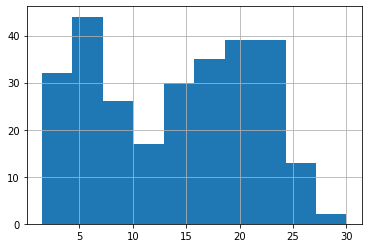

In [5]:
df['bicarb'].hist()

In [6]:
hist

# Trun off annoying ipykernel warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import seaborn as sns
from tableone import TableOne
# Data import and cleaning
wd = '/Volumes/PEDS/RI Biostatistics Core/Shared/Shared Projects/Laura/BDC/Projects/Kimber Simmons/New Onset Dosing/Data_Cleaned/'
df = pd.read_csv(wd+'new_onset_doses.csv',na_values='.')
df.set_index(['MRN'],inplace=True)
# Format columns
# Convert all ages to months
df['Age'] = [int(a.split()[0])*12 if 'year' in a else int(a.split()[0]) for a in df['Age']]
# Replace detection limit of bicarb with half the value
df['bicarb'] = [2.5 if '<' in str(b) and '5' in str(b) else 1.5 if '<' in str(b) and '3' in str(b) else float(b) for b in df['bicarb']]
# Make table 1
cols = ['Age','bicarb','Sex','puberty_yn','Race','Ethnicity','Insurance']
# Print
t1 = TableOne(df,columns=cols,display_all=True,
             normal_test=True,tukey_test=True,dip_test=True)
t1
df['bicarb'].hist()
h

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
